<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/PWM_UnitCell_Triangle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Pulse Width Modulation - Unit Cells for Falling Sawtooth</h1></b>

Dr. Bingsen Wang

12/3/2023
</center>

#Python Code
The Python code illustrates the basic PWM with the concept of unit cells.  

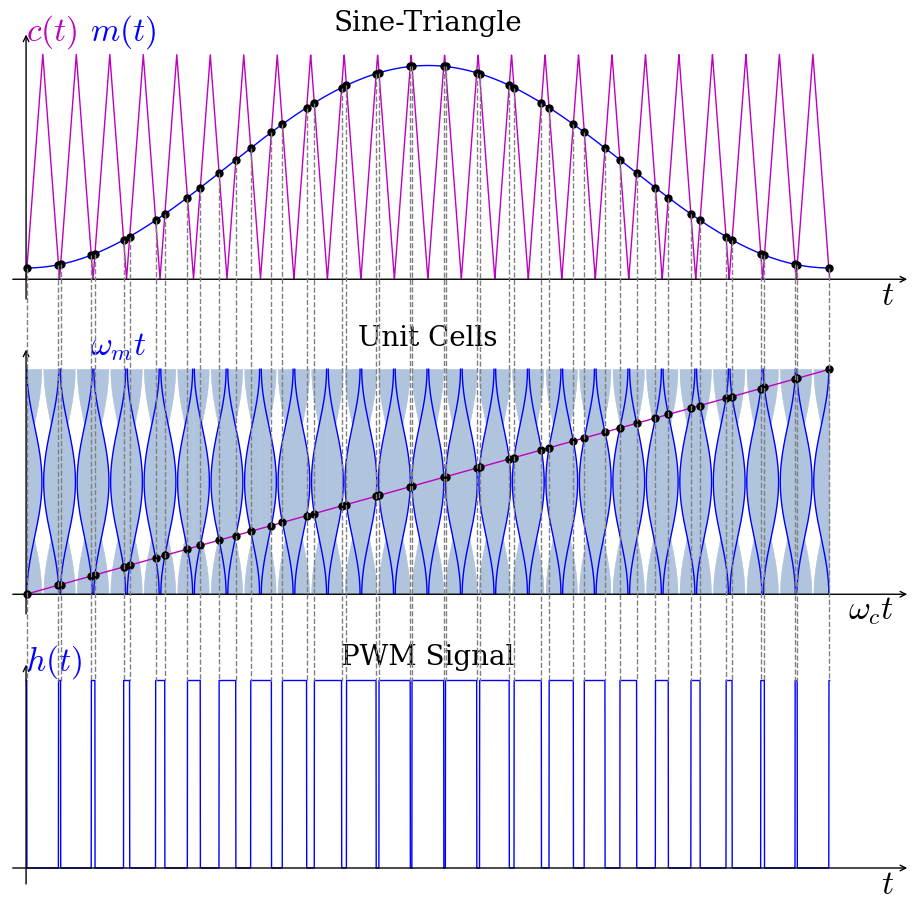

In [14]:
import matplotlib
from os import linesep
from numpy import linspace,cos,pi,arccos,heaviside,array,sort,concatenate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import animation,rc
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#functions
def carr(f,t): #carrier
  return 1/pi*arccos(cos(2*pi*f*t))

def m(MI,f,theta,t): #modulation function
  return (MI*cos(2*pi*f*t + theta)+1)/2

def h(ct,mt): #PWM switching function
  return heaviside(mt-ct,0)

def ucb(MI,x0,y): #unit cell boundary
  xright = x0 + (-0.5*MI*cos(y) +0.5)*pi
  xleft = x0 - (-0.5*MI*cos(y) + 0.5)*pi
  return xleft,xright

# define the function to be solved
def y(x,*data):
  MI,fm,theta,fc = data
  return m(MI,fm,theta,x) - carr(fc,x)

#solving for intersection points
def intersectionPoints(MI,fm,theta,fc):
  ts=[] #list for intersection points
  for k in range(fc):
    ts.append(fsolve(y,1/fc*(0.25+k),args=(MI,fm,theta,fc))[0])
    ts.append(fsolve(y,1/fc*(0.75+k),args=(MI,fm,theta,fc))[0])
  return array(ts)

# draw dotted line between two sets of points in two different plots
def l2Ax(fig,ax1,ax2,ps1,ps2):
  line_set = []
  transFigure = fig.transFigure.inverted()
  for k in range(len(ps1[0])):
    p1 = transFigure.transform(ax1.transData.transform([ps1[0][k],ps1[1][k]]))
    p2 = transFigure.transform(ax2.transData.transform([ps2[0][k],ps2[1][k]]))
    line = matplotlib.lines.Line2D((p1[0],p2[0]),(p1[1],p2[1]),
                      transform=fig.transFigure,ls='--',color='gray', lw=1)
    line_set.append(line)
  fig.lines = line_set
  return

#parameters
Nf = 120 # number of frames
fc = 24 # carrier frequency
Np = fc*200 # number of points
theta = 0 #phase angle of modulation function
fm = 1 # fundamental frequency
MI = 0.9 # modulation index
MI_v = linspace(-MI,MI,Nf)

#time series
t=linspace(0,1,Np)

#sine-triangle
ct = carr(fc,t) #carrier time-domain signal

#unit cell
uc_y = 2*pi*fm*t

#set up figures
fig = plt.figure(figsize=(9,9))
fig.tight_layout()
ax_frame = [[[0, 0.65, 1, .3], [-.02,1.1], [-.1,1.1]], #sine & triangle
            [[0, 0.3,   1, .3], [-.02,1.1], [-.1,1.1]], # unit cell
            [[0, 0,   1, .25], [-.02,1.1], [-.1,1.1]], # pwm based on unit cell
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[[['$c(t)$','$m(t)$'], '$t$'],
        [['',r'$\omega_m t$'], r'$\omega_c t$'],
        [['$h(t)$'], '$t$'],
        ] #yx axes labels
titles = ['Sine-Triangle',
          'Unit Cells',
          'PWM Signal']
clst=[['m','b'],['m','b'],['b']] #colors of lines
ax_lst=[] #axis list or the list of subplots
lines_lst = [] #array for all lines
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
  ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
  for i in range(len(ax_lbl[k][0])):
    lines_lst.append(ax.plot([], [], clst[k][i], lw=1)[0])
    y_text=ax.text(0.08*i,ym,ax_lbl[k][0][i],size=24,va='center',color=clst[k][i]) #y label
  if k==0:
    lines_lst.append(ax.plot([], [], 'k',marker='o',ms=5,ls='')[0])
  if k==1:
    for ii in range(2*fc-1):
      lines_lst.append(ax.plot([], [], clst[k][1], lw=1)[0])
    lines_lst.append(ax.plot([], [], 'k',marker='o',ms=5,ls='')[0])
  ax.text(xm-.02,0,ax_lbl[k][-1],size=24,va='top',ha='right') #x-axis label
  ax_lst[k].text(0.5,ax_frame[0][2][1]+0.1,titles[k],va='top',ha='center',size=20)


lines_lst[0].set_data(t,ct) #carrier signal does not change
lines_lst[0].set_linewidth(1)
fill_lst=[]

# animation function. This is called sequentially
def animate(i):
  mt = m(MI_v[i],fm,0,t) #modulation function time series
  ht = h(ct,mt) #pwm signal time series
  ts = intersectionPoints(MI_v[i],fm,theta,fc) #intersection points
  # ts2 = (linspace(1,fc,fc))/fc
  # ts = concatenate([ts1,ts2])
  mts = m(MI_v[i],fm,0,array(ts))
  lines_lst[1].set_data(t,mt)
  lines_lst[2].set_data(ts,mts)
  l2Ax(fig,ax_lst[0],ax_lst[2],[ts,mts],[ts,ts*0+1]) # draw the dotted lines

  lines_lst[3].set_data(t,t)
  lines_lst[3].set_linewidth(1)
  for k in range(fc):
    uc_x1, uc_x2 = ucb(MI_v[i],k*2*pi + pi,uc_y)
    lines_lst[4+2*k].set_data(uc_x1/(2*pi*fc),uc_y/(2*pi))
    lines_lst[4+2*k+1].set_data(uc_x2/(2*pi*fc),uc_y/(2*pi))
    if i==0:
      fill_lst.append(ax_lst[1].fill_betweenx(uc_y/(2*pi),uc_x1/(2*pi*fc),k/fc,fc='lightsteelblue'))
      fill_lst.append(ax_lst[1].fill_betweenx(uc_y/(2*pi),uc_x2/(2*pi*fc),(k+1)/fc,fc='lightsteelblue'))
    else:
      uc_x10,uc_x20 = ucb(MI_v[i-1],pi+k*2*pi,uc_y)
      ax_lst[1].fill_betweenx(uc_y/(2*pi),uc_x10/(2*pi*fc),k/fc,fc='w')
      ax_lst[1].fill_betweenx(uc_y/(2*pi),uc_x20/(2*pi*fc),(k+1)/fc,fc='w')
      fill_lst[2*k]=ax_lst[1].fill_betweenx(uc_y/(2*pi),uc_x1/(2*pi*fc),
                                          k/fc,fc='lightsteelblue')
      fill_lst[2*k+1]=ax_lst[1].fill_betweenx(uc_y/(2*pi),uc_x2/(2*pi*fc),
                                          (k+1)/fc,fc='lightsteelblue')
  lines_lst[4+2*fc].set_data(ts,ts)
  lines_lst[5+2*fc].set_data(t,ht)
  return

anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"PWM_unitCellTriangle.mp4"
writervideo = animation.FFMpegWriter(fps=6)
anim.save(fn, writer=writervideo,dpi = 120)